In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lmfit
from lmfit import  Model, Parameters
lmfit.__version__

'0.9.10'

In [2]:
import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier :
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')

In [3]:
import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier :
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')

In [4]:
datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

In [5]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [6]:
dpi=400

In [7]:
def fct_old_latence(data, time, w1=300, w2=50, off=50, crit=0.17) :
    
    from scipy import stats
    
    tps = time #np.arange(len(data))
    a = None
    for t in range(len(time)-(w1+off+w2)-300) :
        slope1, intercept1, r_, p_value, std_err = stats.linregress(tps[t:t+w1], data[t:t+w1])
        slope2, intercept2, r_, p_value, std_err = stats.linregress(tps[t+w1+off:t+w1+off+w2], data[t+w1+off:t+w1+off+w2])
        diff = abs(slope2) - abs(slope1)
        if abs(diff) >= crit :
            a = True
            tw = time[t:t+w1+off+w2]
            timew = np.linspace(np.min(tw), np.max(tw), len(tw))

            fitLine1 = slope1 * timew + intercept1
            fitLine2 = slope2 * timew + intercept2

            idx = np.argwhere(np.isclose(fitLine1, fitLine2, atol=0.1)).reshape(-1)
            old_latence = timew[idx]
            break
    
    if a is None :
        old_latence = np.nan
        slope1, intercept1, slope2, intercept2, t = 0,0,0,0,0

    return(old_latence, slope1, intercept1, slope2, intercept2, t)

In [8]:
def Fit(data, trial=10, block=0, plot=True, nb_plot=10, fig_width=15, t_titre=35, t_label=20) :

    
    fig, axs = plt.subplots(1, 1, figsize=(fig_width, 1*(fig_width*1/2)/1.6180))
    fig1, axs1 = plt.subplots(1, 1, figsize=(fig_width, 1*(fig_width*1/2)/1.6180))
    

    trial_data = trial + N_trials*block

    data_x = data[trial_data]['x']
    data_y = data[trial_data]['y']
    trackertime = data[trial_data]['trackertime']

    StimulusOn = data[trial_data]['events']['msg'][10][0]
    StimulusOf = data[trial_data]['events']['msg'][14][0]
    TargetOn = data[trial_data]['events']['msg'][15][0]
    TargetOff = data[trial_data]['events']['msg'][16][0]
    saccades = data[trial_data]['events']['Esac']
    trackertime_0 = data[trial_data]['trackertime'][0]
    bino = p[trial, block, 0]

    gradientx_deg =ANEMO.velocity_deg(data_x, exp['px_per_deg']) 
    gradienty_deg =ANEMO.velocity_deg(data_y, exp['px_per_deg']) 


    #-------------------------------------------------
    # SUPPRESSION DES SACCADES
    #-------------------------------------------------
    stop_recherche_misac = TargetOn-trackertime_0+100
    #misac = ANEMO.Microsaccade(gradientx_deg[:stop_recherche_misac], gradienty_deg[:stop_recherche_misac], trackertime_0=trackertime_0)
    #saccades.extend(misac)

    gradient_deg_NAN = ANEMO.suppression_saccades(gradientx_deg, saccades, trackertime)
    #-------------------------------------------------

    start = TargetOn
    StimulusOn_s = StimulusOn - start
    StimulusOf_s = StimulusOf - start
    TargetOn_s = TargetOn - start
    TargetOff_s = TargetOff - start
    trackertime_s = trackertime - start
    

    debut  = TargetOn - trackertime_0
    vitesse, x = gradient_deg_NAN, np.arange(len(trackertime))

    #-------------------------------------------------
    # FIT
    #-------------------------------------------------

    tau_init = [15.,13.,80.]
    maxi_init = [15.,1.,40.]
    latence_init = [TargetOn-trackertime_0+100,TargetOn-trackertime_0+75,'STOP']
    start_anti_init = [TargetOn-trackertime_0-100, StimulusOf-trackertime_0-200, TargetOn-trackertime_0-75]
    v_anti_init = [0.,-40.,40.]
    
    
    result_deg = ANEMO.Fit_exponentiel(gradient_deg_NAN, trackertime, TargetOn=TargetOn, StimulusOf=StimulusOf, saccades=saccades, bino=bino)

    start_anti = result_deg.values['start_anti']-debut
    v_anti = result_deg.values['v_anti']
    latence = result_deg.values['latence']-debut
    tau = result_deg.values['tau']
    maxi = result_deg.values['maxi']
    
    init_fit = ANEMO.fct_exponentiel(np.arange(len(trackertime[:-250])), bino, start_anti_init[0], v_anti_init[0], latence_init[0], tau_init[0], maxi_init[0])
    best_fit = ANEMO.fct_exponentiel(np.arange(len(trackertime[:-250])), bino, start_anti+debut, v_anti, latence+debut, tau, maxi)
    #-------------------------------------------------


    #-----------------------------------------------------------------------------------------------------------
    # vieux paramètres
    #-----------------------------------------------------------------------------------------------------------
    old_latence, slope1, intercept1, slope2, intercept2, t = fct_old_latence(gradient_deg_NAN, trackertime_s)
    
    a1, b1 = TargetOn-trackertime_0+500, TargetOn-trackertime_0+700
    old_max = np.nanmean(gradient_deg_NAN[a1:b1])
    
    old_v_anti = np.nanmean(gradient_deg_NAN[TargetOn-trackertime_0-50:TargetOn-trackertime_0+50])#/0.1
    old_v_anti_fit = np.nanmean(best_fit[int(start_anti)+debut:int(latence)+debut])
    #-------------------------------------------------
    
    for a in [axs, axs1] :
        a.set_title('True trial', fontsize=t_titre, x=0.5, y=1.05)
        a.set_xlabel('Time (ms)', fontsize=t_label)
        a.set_ylabel('velocity (°/s)', fontsize=t_label)
        
        a.axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
        a.axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
        a.axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)
        for s in range(len(saccades)) :
            a.axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

        a.axis([StimulusOn_s-10, TargetOff_s+10, -40, 40])
        a.plot(trackertime_s, gradient_deg_NAN, color='k', alpha=0.3, lw=1)
        
        a.text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 31, "GAP", color='k', fontsize=t_label*1.5, ha='center', va='center', alpha=0.5)
        a.text((StimulusOf_s-750)/2, 31, "FIXATION", color='k', fontsize=t_label*1.5, ha='center', va='center', alpha=0.5)
        a.text((750-TargetOn_s)/2, 31, "PURSUIT", color='k', fontsize=t_label*1.5, ha='center', va='center', alpha=0.5)
        

    #------------------------------------------------------------------------------------------
    # FIG 1
    #------------------------------------------------------------------------------------------
    axs.plot(trackertime_s[:-250], init_fit, 'k--', linewidth=1)
    axs.plot(trackertime_s[:-250], best_fit, color='r', linewidth=1)
    
    # V_a ------------------------------------------------------------------------
    axs.text((trackertime_s[int(start_anti+debut)]+trackertime_s[int(latence+debut)])/2, 15,
            r"Anticipation", color='r', fontsize=t_label, ha='center', va='center')
    axs.text((trackertime_s[int(start_anti+debut)]+trackertime_s[int(latence+debut)])/2, best_fit[int(start_anti+debut)]-10,
            "A$_a$ = %0.2f °/s$^2$ \n \nV$_a$ = %0.2f °/s"%(v_anti, old_v_anti_fit), color='r', fontsize=t_label/1.5,
             ha='center', va='top')
    
    axs.plot(trackertime_s[int(start_anti+debut):int(latence+debut)], best_fit[int(start_anti+debut):int(latence+debut)],c='r', linewidth=2)
    axs.annotate('', xy=(trackertime_s[int(latence+debut)], best_fit[int(latence+debut)]-3), xycoords='data', fontsize=t_label/1.5,
                xytext=(trackertime_s[int(start_anti+debut)], best_fit[int(start_anti+debut)]-3), textcoords='data', arrowprops=dict(arrowstyle="->", color='r'))

    # Start_a --------------------------------------------------------------------
    axs.text(trackertime_s[int(start_anti+debut)]-25, -30, "Anticipation Onset",
            color='k', alpha=0.7, fontsize=t_label, ha='right', va='bottom')
    
    axs.bar(trackertime_s[int(start_anti+debut)], 80, bottom=-40, color='k', width=4, linewidth=0, alpha=0.7)
    axs.text(trackertime_s[int(start_anti+debut)]-25, -35, "%0.2f ms"%(start_anti),
            color='k', alpha=0.7, fontsize=t_label/1.5, ha='right')
    # latence --------------------------------------------------------------------
    axs.text(trackertime_s[int(latence+debut)]+25, -30, "Latency"%(latence),
            color='firebrick', fontsize=t_label, va='bottom')
    axs.bar(trackertime_s[int(latence+debut)], 80, bottom=-40, color='firebrick', width=4, linewidth=0, alpha=1)
    axs.text(trackertime_s[int(latence+debut)]+25, -35, "%0.2f ms"%(latence),
            color='firebrick', fontsize=t_label/1.5, va='center')
    # tau ------------------------------------------------------------------------
    axs.plot(trackertime_s[int(latence+debut):int(latence+debut)+250], best_fit[int(latence+debut):int(latence+debut)+250], c='darkred', linewidth=2)
    axs.text(trackertime_s[int(latence+debut)]+70+t_label, (best_fit[int(latence+debut)]),
            r"  %0.2f ms"%(tau), color='darkred',va='bottom', fontsize=t_label/1.5)
    axs.annotate(r'$\tau$', xy=(trackertime_s[int(latence+debut)]+29, best_fit[int(latence+debut)+29]),
                 xycoords='data', fontsize=t_label/1., color='darkred', va='bottom',
                xytext=(trackertime_s[int(latence+debut)]+70, best_fit[int(latence+debut)-15]), textcoords='data', arrowprops=dict(arrowstyle="->", color='darkred'))
    # Max ------------------------------------------------------------------------
    maxi = maxi + best_fit[int(latence+debut)]
    baba = 500
    
    axs.text(TargetOn_s+baba+25, maxi+5, "Steady State", color='k', va='bottom', fontsize=t_label)
    
    
    axs.plot(trackertime_s, np.zeros(len(trackertime_s)), '--k', linewidth=1, alpha=0.5)
    axs.plot(trackertime_s[int(latence+debut):], np.ones(len(trackertime_s[int(latence+debut):]))*best_fit[int(latence+debut)+250], '--k', linewidth=1, alpha=0.5)
    axs.text(TargetOn_s+baba+25, maxi/2, "%0.2f °/s"%(maxi), color='k', va='center', fontsize=t_label/1.5)
    axs.annotate('', xy=(TargetOn_s+baba, 0), xycoords='data', fontsize=t_label/1.5,
                xytext=(TargetOn_s+baba, best_fit[int(latence+debut)+250]), textcoords='data', arrowprops=dict(arrowstyle="<->"))
    
    
    #------------------------------------------------------------------------------------------
    # FIG 2
    #------------------------------------------------------------------------------------------
    # V_a ------------------------------------------------------------------------
    axs1.text(0, 20, "Anticipation", color='k', fontsize=t_label, ha='center', va='center')
    axs1.text(TargetOn_s, 15, "mean(t$_{-50}$,t$_{50}$)", color='k', fontsize=t_label/1.5, ha='center', va='top')
    axs1.axvspan(TargetOn_s-50, TargetOn_s+50, color='c', alpha=0.3)
    
    axs1.text(TargetOn_s, -20, "V$_a$ = %0.2f °/s"%(old_v_anti), color='k', fontsize=t_label/1.5, ha='center',
              va='center')
    
    # latence --------------------------------------------------------------------
    axs1.text(old_latence+25, -30, "Latency", color='k', fontsize=t_label, va='bottom')
    
    w1, w2, off, crit = 300, 50, 50, 0.2
    tw = trackertime_s[t:t+w1+off+w2] #[x1:x1+w1]
    timew = np.linspace(np.min(tw), np.max(tw), len(tw))
    
    fitLine1 = slope1 * timew + intercept1
    axs1.plot(tw[:w1+off+50], fitLine1[:w1+off+50], '--k', linewidth=1.5)
    axs1.plot(tw[:w1], fitLine1[:w1], c='k', linewidth=1.5)
    
    fitLine2 = slope2 * timew + intercept2
    axs1.plot(tw[w1:], fitLine2[w1:], '--k', linewidth=1.5)
    axs1.plot(tw[w1+off:], fitLine2[w1+off:], c='k', linewidth=1.5)

    axs1.bar(old_latence, 80, bottom=-40, color='c', width=4, linewidth=0, alpha=1)
    
    axs1.text(old_latence+25, -35, "%0.2f ms"%(old_latence), color='k', fontsize=t_label/1.5, va='center')    
    
    # Max ------------------------------------------------------------------------
    axs1.text(600, -20, "Steady State", color='k', fontsize=t_label, ha='center', va='center')
    axs1.text(600, -25, "mean(t$_{500}$,t$_{700}$)",
              color='k', ha='center',va='top', fontsize=t_label/1.5)
    
    axs1.plot(trackertime_s, np.zeros(len(trackertime_s)), '--k', linewidth=1, alpha=0.5)
    axs1.plot(trackertime_s[int(old_latence+debut):], np.ones(len(trackertime_s[int(old_latence+debut):]))*old_max, '--k', linewidth=1, alpha=0.5)
    axs1.axvspan(TargetOn_s+500, TargetOn_s+700, color='c', alpha=0.3)

    
    axs1.text(TargetOn_s+600, maxi/2, "%0.2f °/s"%(old_max), color='k', ha='center',va='top', fontsize=t_label/1.5)
    axs1.annotate('', xy=(TargetOn_s+520, 0), xycoords='data', fontsize=t_label/1.5,
                xytext=(TargetOn_s+520, old_max), textcoords='data', arrowprops=dict(arrowstyle="<->"))
    #------------------------------------------------------------------------------------------
    
    fig.tight_layout()
    fig.savefig('../2018-05-04_Poster_Grenobe/test2/figures/Fit_reel.png', dpi=dpi)
    
    fig1.tight_layout()
    fig1.savefig('../2018-05-04_Poster_Grenobe/test2/figures/Old_methods_reel.png', dpi=dpi)
    
    plt.show()

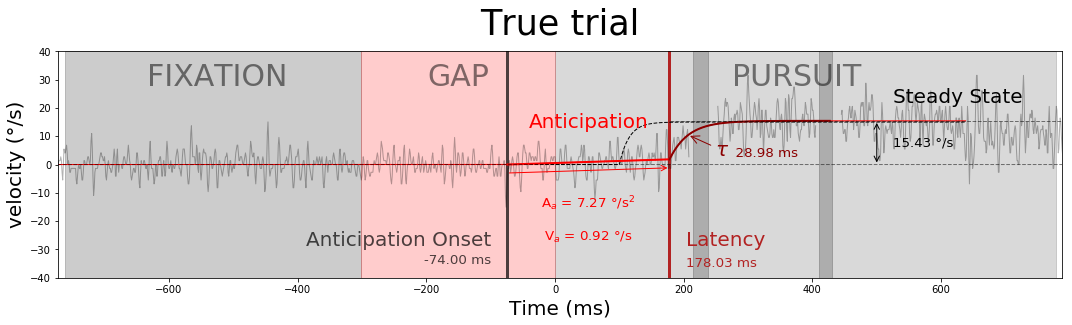

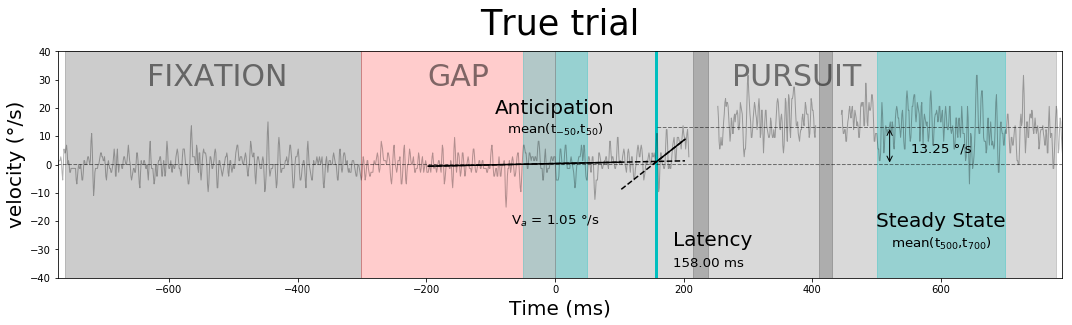

In [9]:
Fit(data, trial=21, block=0) #trial=21

In [10]:
def plot(x, trial, start_antifit, v_antifit, latencefit, taufit, maxifit, bruit, TargetOn, StimulusOf,
        fig_width=15, t_titre=35, t_label=20) :
           
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, 1*(fig_width*1/2)/1.6180))
    fig1, ax1 = plt.subplots(1, 1, figsize=(fig_width, 1*(fig_width*1/2)/1.6180))
    
    np.random.seed(7)
    

    param_fit={'tau':taufit, 'maxi':maxifit, 'v_anti':v_antifit, 'latence':latencefit,
               'start_anti':start_antifit}

    bino = exp['p'][trial][0][0]
    start_anti_true = param['start_anti'][0][trial]+TargetOn
    v_anti_true = param['v_anti'][0][trial]
    latence_true = param['latence'][0][trial]+TargetOn
    tau_true = param['tau'][0][trial]
    maxi_true = param['maxi'][0][trial]

    true_test = ANEMO.fct_exponentiel(x, bino, start_anti_true, v_anti_true, latence_true, tau_true, maxi_true)
    
    test = ANEMO.fct_exponentiel(x, bino, start_anti_true, v_anti_true, latence_true, tau_true, maxi_true)+np.random.rand(len(x))*bruit
    test = test-np.random.rand(len(x))*bruit
    #test[start_sac:stop_sac] = np.arange(0, (stop_sac-start_sac), 1)*np.nan

    debut = TargetOn
    x_s = x-debut
    #-------------------------------------------------
    # FIT
    #-------------------------------------------------
    result_deg = ANEMO.Fit_exponentiel(test, x, bino, param_fit=param_fit, sup=None)

    start_anti_fit = result_deg.values['start_anti']
    v_anti_fit = result_deg.values['v_anti']
    latence_fit = result_deg.values['latence']
    tau_fit = result_deg.values['tau']
    maxi_fit = result_deg.values['maxi']
    
    init_fit = ANEMO.fct_exponentiel(x, bino, start_antifit[0], v_antifit[0], latencefit[0], taufit[0], maxifit[0])
    best_fit = ANEMO.fct_exponentiel(x, bino, start_anti_fit, v_anti_fit, latence_fit, tau_fit, maxi_fit)
    #-------------------------------------------------

    #-----------------------------------------------------------------------------------------------------------
    # vieux paramètres
    #-----------------------------------------------------------------------------------------------------------
    old_latence, slope1, intercept1, slope2, intercept2, t  = fct_old_latence(test, x_s)
    old_max = np.abs(np.nanmean(test[TargetOn+500:TargetOn+700]))
    old_v_anti = np.nanmean(test[TargetOn-50:TargetOn+50])
    old_v_anti_true = np.nanmean(true_test[int(start_anti_true):int(latence_true)])
    old_v_anti_fit = np.nanmean(best_fit[int(start_anti_fit):int(latence_fit)])
    #-----------------------------------------------------------------------------------------------------------

    for a in [ax, ax1] :
        a.set_title('Simulated trial', fontsize=t_titre, x=0.5, y=1.05)
        a.set_xlabel('Time (ms)', fontsize=t_label)
        a.set_ylabel('velocity (°/s)', fontsize=t_label)
        
        a.plot(x-TargetOn, test, c='k', alpha=0.3, lw=1)
        
        a.axvspan(0-TargetOn, StimulusOf-TargetOn, color='k', alpha=0.2)
        a.axvspan(StimulusOf-TargetOn, TargetOn-TargetOn, color='r', alpha=0.2)
        a.axvspan(TargetOn-TargetOn, len(x), color='k', alpha=0.15)
        a.axis([-750, 750, -39.5, 39.5])

    #------------------------------------------------------------------------------------------
    # FIG 1
    #------------------------------------------------------------------------------------------
    baba = 500
    #------------------------------------------------------------------------------------------
    ax.plot(x-TargetOn, init_fit, 'k--')
    ax.plot(x-TargetOn, best_fit, c='r')
    
    # V_a ------------------------------------------------------------------------
    ax.text((x_s[int(start_anti_fit)]+x_s[int(latence_fit)])/2, 15,
            r"Anticipation", color='r', fontsize=t_label, ha='center')
    ax.annotate('', xy=(x_s[int(latence_fit)], best_fit[int(latence_fit)]-3), xycoords='data', fontsize=t_label/1.5,
                xytext=(x_s[int(start_anti_fit)], best_fit[int(start_anti_fit)]-3), textcoords='data', arrowprops=dict(arrowstyle="->", color='r'))
    ax.text((x_s[int(start_anti_fit)]+x_s[int(latence_fit)])/2, best_fit[int(start_anti_fit)]-5,
            "A$_a$ = %0.2f °/s$^2$ \n(initially %0.2f °/s$^2$) \n\n V$_a$ = %0.2f °/s \n(initially %0.2f °/s)"%(v_anti_fit, v_anti_true, old_v_anti_fit, old_v_anti_true),
            color='r', fontsize=t_label/1.5, ha='center', va='top')
    # Start_a --------------------------------------------------------------------
    ax.text(x_s[int(start_anti_fit)]-25, -20, "Anticipation Onset",
            color='k', alpha=0.7, fontsize=t_label, ha='right', va='center')

    
    ax.bar(x_s[int(start_anti_fit)], 80, bottom=-40, color='k', width=4, linewidth=0, alpha=0.7)
    ax.text(x_s[int(start_anti_fit)]-25, -35,
            "%0.2f ms \n(initially %0.2f ms)"%(start_anti_fit-debut, start_anti_true-debut),
            color='k', alpha=0.7, fontsize=t_label/1.5, ha='right', va='bottom')
    # latence --------------------------------------------------------------------
    ax.text(x_s[int(latence_fit)]+25, -20, "Latency",
            color='firebrick', fontsize=t_label, va='center')
    
    ax.bar(x_s[int(latence_fit)], 80, bottom=-40, color='firebrick', width=4, linewidth=0, alpha=1)
    ax.text(x_s[int(latence_fit)]+25, -35, "%0.2f ms \n(initially %0.2f ms)"%(latence_fit-debut, latence_true-debut),
            color='firebrick', fontsize=t_label/1.5, va='bottom')
    # tau ------------------------------------------------------------------------
    ax.text(x_s[int(latence_fit)]+70+t_label, (best_fit[int(latence_fit)+31]-(t_label/1.5)),
            "  %0.2f ms \n(initially %0.2f ms)"%(tau_fit, tau_true), color='darkred',va='bottom', fontsize=t_label/1.5)
    ax.annotate(r'$\tau$', xy=(x_s[int(latence_fit)]+31, best_fit[int(latence_fit)+31]),
                 xycoords='data', fontsize=t_label/1., color='darkred', va='bottom',
                xytext=(x_s[int(latence_fit)]+70, best_fit[int(latence_fit)-15]), textcoords='data', arrowprops=dict(arrowstyle="->", color='darkred'))
    # Max ------------------------------------------------------------------------
    ax.text(baba+25, (best_fit[int(latence_fit)+400])+5, "Steady State", color='k', va='bottom', fontsize=t_label)
    
    ax.plot(x_s, np.zeros(len(x)), '--k', linewidth=1, alpha=0.5)
    ax.plot(x_s[int(latence_fit):], np.ones(len(x[int(latence_fit):]))*best_fit[int(latence_fit)+250], '--k', linewidth=1, alpha=0.5)
    ax.text(baba+25, (best_fit[int(latence_fit)+400])/2, "%0.2f °/s \n(initially %0.2f °/s)"%(maxi_fit, maxi_true), color='k', va='center', fontsize=t_label/1.5)
    ax.annotate('', xy=(baba, 0), xycoords='data', fontsize=t_label/1.5,
                xytext=(baba, best_fit[int(latence_fit)+250]), textcoords='data', arrowprops=dict(arrowstyle="<->"))
    
    
    #------------------------------------------------------------------------------------------
    # FIG 2
    #------------------------------------------------------------------------------------------
    # V_a ------------------------------------------------------------------------
    ax1.text(0, 20, "Anticipation", color='k', fontsize=t_label, ha='center', va='center')
    
    ax1.axvspan(-50, 50, color='c', alpha=0.3)
    ax1.text(0, -25, "V$_a$ = %0.2f °/s \n(initially %0.2f °/s)"%(old_v_anti, old_v_anti_true),
             color='k', fontsize=t_label/1.5, ha='center', va='top')
    # latence --------------------------------------------------------------------
    ax1.text(old_latence+25, -20, "Latency", color='k', fontsize=t_label, va='center')
    
    w1, w2, off, crit = 300, 50, 50, 0.2
    tw = x_s[t:t+w1+off+w2]
    timew = np.linspace(np.min(tw), np.max(tw), len(tw))
    
    fitLine1 = slope1 * timew + intercept1
    ax1.plot(tw[:w1+off+50], fitLine1[:w1+off+50], '--k', linewidth=1.5)
    ax1.plot(tw[:w1], fitLine1[:w1], c='k', linewidth=1.5)
    
    fitLine2 = slope2 * timew + intercept2
    ax1.plot(tw[w1:], fitLine2[w1:], '--k', linewidth=1.5)
    ax1.plot(tw[w1+off:], fitLine2[w1+off:], c='k', linewidth=1.5)

    
    ax1.bar(old_latence, 80, bottom=-40, color='c', width=4, linewidth=0, alpha=1)
    ax1.text(old_latence+25, -35, "%0.2f ms \n(initially %0.2f ms)"%(old_latence, latence_true-debut),
            color='k', fontsize=t_label/1.5, va='bottom')

    # Max ------------------------------------------------------------------------
    ax1.text(600, -20, "Steady State", color='k', fontsize=t_label, ha='center', va='center')
    
    ax1.axvspan(500, 700, color='c', alpha=0.3)
    
    #ax1.plot(x-TargetOn, np.ones(len(x))*(bino*2-1)*old_max, color='c')
    ax1.plot(x_s, np.zeros(len(x)), '--k', linewidth=1, alpha=0.5)
    ax1.plot(x_s[int(old_latence)+TargetOn:], np.ones(len(x_s[int(old_latence)+TargetOn:]))*old_max, '--k', linewidth=1, alpha=0.5)
    
    
    ax1.text(545, old_max/2, "%0.2f °/s \n(initially %0.2f °/s)"%(old_max, maxi_true), color='k',
             va='center', fontsize=t_label/1.5)
    ax1.annotate('', xy=(520, 0), xycoords='data', fontsize=t_label/1.5,
                xytext=(520, old_max), textcoords='data', arrowprops=dict(arrowstyle="<->"))
    #------------------------------------------------------------------------------------------
    
    
    
    fig.tight_layout()
    fig1.tight_layout()
    
    fig.savefig('../2018-05-04_Poster_Grenobe/test2/figures/Fit_simulation.png', dpi=dpi)
    fig1.savefig('../2018-05-04_Poster_Grenobe/test2/figures/Old_methods_simulation.png', dpi=dpi)
    
    plt.show()

In [11]:
x = np.arange(0, 1500, 1)
TargetOn, StimulusOf = 750, 750-300

In [12]:
def defaut():
    start_anti_fit = [TargetOn-100, StimulusOf-200, TargetOn+75]
    latence_fit = [TargetOn+100, TargetOn+75, len(x)]
    v_anti_fit = [0., -40., 40.]
    tau_fit = [15., 13., 80.]
    maxi_fit = [15., 1., 40.]

    return(start_anti_fit, latence_fit, v_anti_fit, tau_fit, maxi_fit)

In [13]:
start_anti_fit, latence_fit, v_anti_fit, tau_fit, maxi_fit = defaut()

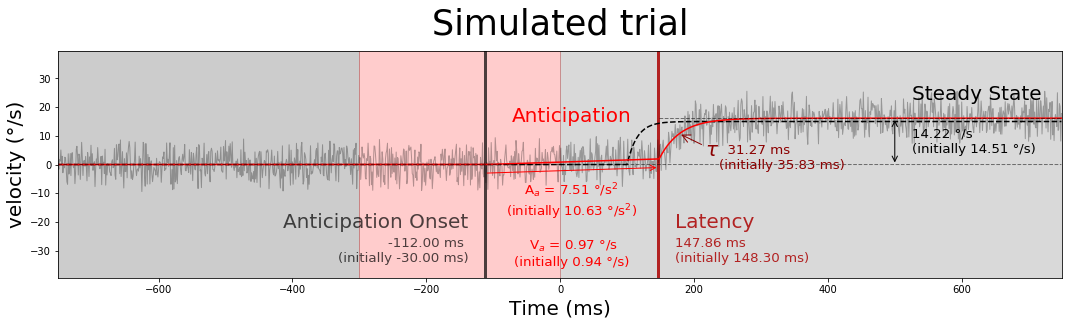

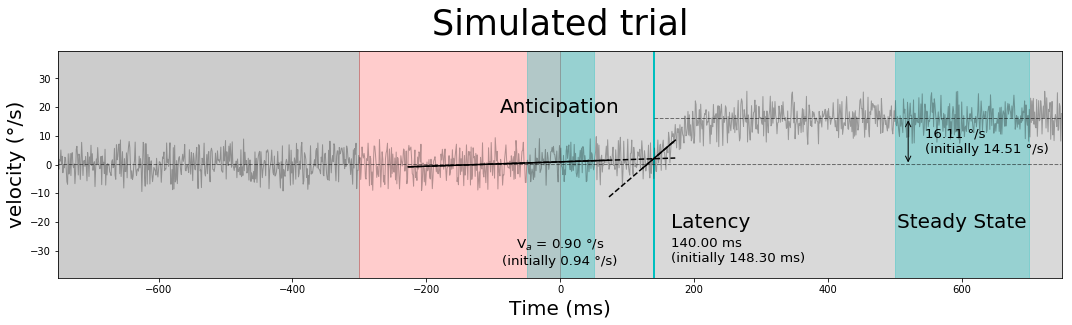

In [14]:
plot(x, 20, start_anti_fit, v_anti_fit, latence_fit, tau_fit, maxi_fit, 10, TargetOn, StimulusOf) # trial20